# Generate Statistics and TIFFs for Site Location Analysis

In [1]:
import os
import json
import numpy as np
import pandas as pd

import initialise
import common
from analysis_utils import calc_statistics

In [2]:
if common.GDAL_DATA is not None:
    os.environ['GDAL_DATA'] = common.GDAL_DATA
from osgeo import gdal
from osgeo import osr

In [3]:
MODEL_DIR = os.path.join(common.MODELS_DIR, 'evaluation_models')
OUTPUT_DIR = os.path.join(common.MAPS_DIR, 'Gridded_sites')
NODATA = common.GDAL_NODATA_VALUE
BANDS = ['RMSE', 'Bias', 'R2', 'Uncertainty']

In [4]:
all_samples = pd.read_csv(os.path.join(common.DATASETS_DIR, 'samples_730days.csv'), index_col=0)
tests = [{'name': 'Nowcasting', 'dir': 'test0'}, {'name': '3-month Projection', 'dir': 'test3'},]
ifile_name = f'ensemble{common.ENSEMBLE_SIZE}_{common.ANALYSIS_MODEL}.csv'
ufile_name = f'ensemble{common.ENSEMBLE_SIZE}_stds.csv'
ofile_names = [f'projection_nowcast_sites.tif', f'projection_3months_sites.tif',]
locations = {}

### Calculate the statistics for each grid cell

In [5]:
def gen_gridded_data(predictions, samples, std_devs, y):
    predict = predictions.merge(samples[['Latitude', 'Longitude', y]], left_index=True, right_index=True)
    predict['Latitude'] = np.ceil((predict.Latitude * 2))/2
    predict['Longitude'] = np.floor((predict.Longitude * 2))/2
    predict['Uncertainty'] = std_devs.mean(axis=1)

    counts = predict.groupby(['Latitude', 'Longitude']).size()
    uncertainty = predict.groupby(['Latitude', 'Longitude'])['Uncertainty'].mean()
    locations = []
    locs = predict.set_index(['Latitude', 'Longitude']).loc[counts[counts >= 10].index].groupby(['Latitude', 'Longitude'])
    ybar = samples[y].mean()
    for col in predict.columns[:-4]:
        l = locs.apply(lambda x: calc_statistics(x[y], x[col], ybar=ybar))
        locations.append(pd.DataFrame(list(l.values), index=l.index))
    locations = pd.concat(locations).groupby(level=[0,1]).mean()
    locations['Uncertainty'] = uncertainty
    locations['NumSamples'] = counts
    return locations

### Summary statistics

In [6]:
def display_summary(locations):
    print('Proportion of grid cells with RMSE < 20:', np.round(locations.RMSE.lt(20).sum() / locations.shape[0], 2), '\n')
    display(pd.DataFrame([locations.min(), locations.median(), locations.mean(), locations.max(), locations.std()],
                         index=['min', 'median', 'mean', 'max', 'std dev']).round(2))

### Region summary

In [7]:
def display_region(locations, long_range, lat_range):
    temp_df = locations.reset_index()
    temp_df = temp_df[temp_df.Latitude.between(lat_range[0], lat_range[1]) & temp_df.Longitude.between(long_range[0], long_range[1])]
    print('RMSE weighted average:', np.round(np.sqrt((temp_df.RMSE ** 2 * temp_df.NumSamples).sum() / temp_df.NumSamples.sum()), 2))
    print('Bias weighted average:', np.round((temp_df.Bias * temp_df.NumSamples).sum() / temp_df.NumSamples.sum(), 2))

### Grid cell LFMC estimation bias

In [8]:
def display_grid_bias(locations):
    print('Proportion of grid cells with under-estimated LFMC:', np.round(locations.Bias.lt(0).sum() / locations.shape[0], 2))
    print('Proportion of grid cells with abs(bias) < 5:', np.round(locations.Bias.between(-5, 5).sum() / locations.shape[0], 2))
    print('Proportion of grid cells with abs(bias) < 10:', np.round(locations.Bias.between(-10, 10).sum() / locations.shape[0], 2))
    print('Proportion of grid cells with abs(bias) > 20:', np.round(locations.Bias.abs().gt(20).sum() / locations.shape[0], 2))

### Generate sites tiff

In [9]:
def gen_locations_tiff(locations, output_file, bands, nodata_value, longitude='Longitude', latitude='Latitude'):
    x_coords = (int(np.floor(locations.index.get_level_values(longitude).min())), int(np.ceil(locations.index.get_level_values(longitude).max())))
    y_coords = (int(np.floor(locations.index.get_level_values(latitude).min())), int(np.ceil(locations.index.get_level_values(latitude).max())))
    x_size = (x_coords[1] - x_coords[0]) * 2 + 1
    y_size = (y_coords[1] - y_coords[0]) * 2 + 1
    multi_index = pd.MultiIndex.from_product([np.linspace(y_coords[0], y_coords[1], y_size), np.linspace(x_coords[0], x_coords[1], x_size)])

    pixel_size = 0.5
    transform = [x_coords[0], pixel_size, 0.0, y_coords[1], 0.0, -pixel_size]

    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)

    driver = gdal.GetDriverByName('GTiff')
    out_map_raster = driver.Create(output_file, x_size, y_size, len(bands), gdal.GDT_Float32)
    out_map_raster.SetGeoTransform(transform)
    out_map_raster.SetProjection(srs.ExportToWkt())

    for num, band in enumerate(bands, 1):
        band_data = locations[band].reindex(multi_index).unstack()[::-1]
        out_map_band = out_map_raster.GetRasterBand(num)
        out_map_band.SetNoDataValue(nodata_value)
        out_map_band.SetDescription(band)
        out_map_band.WriteArray(band_data.values)
        out_map_band.FlushCache()

    del out_map_raster

## Nowcasting

In [10]:
print(f"{tests[0]['name']} Scenario")
print('===================')

with open(os.path.join(MODEL_DIR, 'model_params.json'), 'r') as f:
    model_params = json.load(f)

predict = pd.read_csv(os.path.join(MODEL_DIR, tests[0]['dir'], ifile_name), index_col=0)
std_dev = pd.read_csv(os.path.join(MODEL_DIR, tests[0]['dir'], ufile_name), index_col=0)
samples = all_samples.reindex(predict.index)

locations['nowcasting'] = gen_gridded_data(predict, samples, std_dev, model_params['targetColumn'])
print('\nResults summary')
print('---------------')
display_summary(locations['nowcasting'])

print('\nResults for southern Texas')
print('--------------------------')
display_region(locations['nowcasting'], (-100.0, -98.0), (26.0, 29.5))

print('\nResults for Rocky Mountains')
print('---------------------------')
display_region(locations['nowcasting'], (-118.0, -113.0), (47.0, 50.0))

print('\nBias summary')
print('------------')
display_grid_bias(locations['nowcasting'])

#ofile = os.path.join(OUTPUT_DIR, ofile_names[0])
#gen_locations_tiff(locations['nowcasting'], ofile, BANDS, NODATA)

Nowcasting Scenario

Results summary
---------------
Proportion of grid cells with RMSE < 20: 0.35 



,Count,RMSE,R2,Bias,Uncertainty,NumSamples
min,10.00,4.60,-4.93,-76.52,6.13,10.00
median,39.00,23.72,0.39,0.78,9.00,39.00
mean,51.42,25.54,0.21,0.23,9.11,51.42
max,528.00,102.54,0.99,37.49,14.90,528.00
std dev,48.63,12.03,0.75,15.52,1.56,48.63



Results for southern Texas
--------------------------
RMSE weighted average: 71.97
Bias weighted average: -45.01

Results for Rocky Mountains
---------------------------
RMSE weighted average: 50.03
Bias weighted average: -6.72

Bias summary
------------
Proportion of grid cells with under-estimated LFMC: 0.48
Proportion of grid cells with abs(bias) < 5: 0.26
Proportion of grid cells with abs(bias) < 10: 0.53
Proportion of grid cells with abs(bias) > 20: 0.19


## 3-month Projection

In [11]:
print(f"{tests[1]['name']} Scenario")
print('===========================')

predict = pd.read_csv(os.path.join(MODEL_DIR, tests[1]['dir'], ifile_name), index_col=0)
std_dev = pd.read_csv(os.path.join(MODEL_DIR, tests[1]['dir'], ufile_name), index_col=0)
samples = all_samples.reindex(predict.index)

locations['projection'] = gen_gridded_data(predict, samples, std_dev, model_params['targetColumn'])
print('\nResults summary')
print('---------------')
display_summary(locations['projection'])

print('\nResults for southern Texas')
print('--------------------------')
display_region(locations['projection'], (-100.0, -98.0), (26.0, 29.5))

print('\nResults for Rocky Mountains')
print('---------------------------')
display_region(locations['projection'], (-118.0, -113.0), (47.0, 50.0))

print('\nBias summary')
print('------------')
display_grid_bias(locations['projection'])

#ofile = os.path.join(OUTPUT_DIR, ofile_names[1])
#gen_locations_tiff(locations['projection'], ofile, BANDS, NODATA)

3-month Projection Scenario

Results summary
---------------
Proportion of grid cells with RMSE < 20: 0.33 



,Count,RMSE,R2,Bias,Uncertainty,NumSamples
min,10.00,4.32,-4.48,-87.12,6.49,10.00
median,39.00,23.92,0.36,0.52,9.55,39.00
mean,51.42,26.18,0.19,0.48,9.54,51.42
max,528.00,111.68,0.99,39.67,16.79,528.00
std dev,48.63,12.32,0.72,15.45,1.64,48.63



Results for southern Texas
--------------------------
RMSE weighted average: 78.61
Bias weighted average: -48.98

Results for Rocky Mountains
---------------------------
RMSE weighted average: 50.57
Bias weighted average: -4.84

Bias summary
------------
Proportion of grid cells with under-estimated LFMC: 0.49
Proportion of grid cells with abs(bias) < 5: 0.29
Proportion of grid cells with abs(bias) < 10: 0.54
Proportion of grid cells with abs(bias) > 20: 0.2


In [12]:
locations['differences'] = locations['projection'] - locations['nowcasting']

In [13]:
locations['differences'].describe()

,Count,RMSE,R2,Bias,Uncertainty,NumSamples
count,412.0,412.000000,412.000000,412.000000,412.000000,412.0
mean,0.0,0.636250,-0.015619,0.240589,0.428566,0.0
std,0.0,2.444932,0.180291,2.823189,0.577897,0.0
min,0.0,-6.228400,-0.853600,-10.596400,-0.941863,0.0
25%,0.0,-0.637700,-0.087200,-1.401350,0.041064,0.0
50%,0.0,0.675500,-0.027800,0.305400,0.396821,0.0
75%,0.0,1.937300,0.029650,1.892050,0.753610,0.0
max,0.0,10.536400,0.817400,11.407600,2.792110,0.0


array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

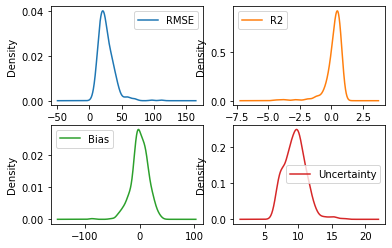

In [14]:
locations['projection'][['RMSE', 'R2', 'Bias', 'Uncertainty']].plot.density(subplots=True, sharex=False, sharey=False, layout=(2,2))

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

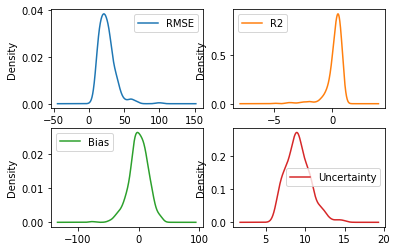

In [15]:
locations['nowcasting'][['RMSE', 'R2', 'Bias', 'Uncertainty']].plot.density(subplots=True, sharex=False, sharey=False, layout=(2,2))

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

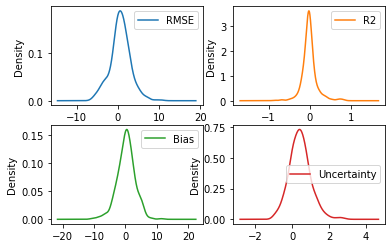

In [16]:
locations['differences'][['RMSE', 'R2', 'Bias', 'Uncertainty']].plot.density(subplots=True, sharex=False, sharey=False, layout=(2,2))

In [17]:
locations['differences'].RMSE[locations['differences'].RMSE.between(-5, 5)].size / locations['differences'].RMSE.size

0.941747572815534

In [18]:
locations['differences'].RMSE[locations['differences'].RMSE.between(0, 5)].size / locations['differences'].RMSE.size

0.5970873786407767

In [19]:
locations['differences'].RMSE[locations['differences'].RMSE < 5].size / locations['differences'].RMSE.size

0.9611650485436893

In [20]:
locations['differences'].RMSE[locations['differences'].RMSE < 0].size / locations['differences'].RMSE.size

0.3640776699029126

In [21]:
locations['projection'].RMSE[locations['projection'].RMSE < 30].size / locations['projection'].RMSE.size

0.7063106796116505

In [22]:
locations['differences'].R2[locations['differences'].R2.between(-0.1, 0.1)].size / locations['differences'].R2.size

0.6383495145631068

In [23]:
locations['differences'].R2[locations['differences'].R2.between(-0.1, 0)].size / locations['differences'].R2.size

0.41504854368932037

In [24]:
locations['differences'].R2[locations['differences'].R2 > 0].size / locations['differences'].R2.size

0.3640776699029126

In [25]:
locations['differences'].R2[locations['differences'].R2 < -0.1].size / locations['differences'].R2.size

0.220873786407767

In [26]:
locations['projection'].R2[locations['projection'].R2 <= 0].size / locations['projection'].R2.size

0.22815533980582525

In [27]:
locations['nowcasting'].R2[locations['nowcasting'].R2 <= 0].size / locations['nowcasting'].R2.size

0.21601941747572814

In [28]:
locations['projection'].Bias.quantile([.10, .20, .30, .40, .50, .60, .70, .80, .90])

0.1   -19.43100
0.2   -10.15496
0.3    -5.56708
0.4    -2.89184
0.5     0.52160
0.6     4.64876
0.7     8.43688
0.8    12.60988
0.9    20.12480
Name: Bias, dtype: float64

In [29]:
locations['nowcasting'].Bias.quantile([.40, .41, .42, .43, .44, .45, .46, .47, .48, .49, .5])

0.40   -2.954760
0.41   -2.683610
0.42   -2.404644
0.43   -2.139578
0.44   -1.714192
0.45   -1.129040
0.46   -0.651252
0.47   -0.391848
0.48   -0.045968
0.49    0.412270
0.50    0.776000
Name: Bias, dtype: float64

In [30]:
locations['projection'].Bias.quantile([.40, .41, .42, .43, .44, .45, .46, .47, .48, .49, .5])

0.40   -2.891840
0.41   -2.273734
0.42   -2.094764
0.43   -1.813734
0.44   -1.696560
0.45   -1.293900
0.46   -1.012996
0.47   -0.709812
0.48   -0.365576
0.49    0.150142
0.50    0.521600
Name: Bias, dtype: float64

In [31]:
locations['projection'].R2.quantile([.10, .20, .30, .40, .50, .60, .70, .80, .90])

0.1   -0.42366
0.2   -0.05012
0.3    0.12878
0.4    0.26952
0.5    0.36360
0.6    0.45136
0.7    0.56516
0.8    0.64400
0.9    0.74964
Name: R2, dtype: float64

In [32]:
locations['projection'].R2.quantile([.23, .33, .50, .67, .75, .76])

0.23    0.005612
0.33    0.183334
0.50    0.363600
0.67    0.526770
0.75    0.593850
0.76    0.598248
Name: R2, dtype: float64

In [33]:
locations['projection'].RMSE.quantile([.10, .20, .30, .40, .50, .60, .70, .80, .90])

0.1    13.63816
0.2    16.86204
0.3    18.75284
0.4    21.58932
0.5    23.91950
0.6    26.36736
0.7    29.67236
0.8    34.03256
0.9    40.42132
Name: RMSE, dtype: float64

In [34]:
locations['projection'].RMSE.quantile([.0, .25, .50, .75, 1])

0.00      4.32020
0.25     17.93630
0.50     23.91950
0.75     31.91935
1.00    111.67600
Name: RMSE, dtype: float64

In [35]:
locations['differences'][(locations['differences'].R2 >= 0) & (locations['differences'].RMSE > 0)]

,,Count,RMSE,R2,Bias,Uncertainty,NumSamples
Latitude,Longitude,,,,,,
43.5,-112.0,0.0,0.0516,0.0002,1.7026,0.377683,0


In [36]:
locations['differences'][(locations['differences'].R2 < 0) & (locations['differences'].RMSE < 0)]

,,Count,RMSE,R2,Bias,Uncertainty,NumSamples
Latitude,Longitude,,,,,,
42.0,-111.0,0.0,-0.0082,-0.0004,-1.8516,0.772679,0


In [37]:
locations['differences'][locations['differences'].RMSE < 0]

Count    RMSE      R2    Bias  Uncertainty  NumSamples
Latitude Longitude                                                        
30.0     -100.5       0.0 -2.7676  0.1992 -6.3764     1.604969           0
         -99.5        0.0 -3.0514  0.3438 -3.8650    -0.529363           0
         -99.0        0.0 -1.4424  0.1676 -1.1866    -0.385751           0
         -98.5        0.0 -3.5908  0.4814 -2.9706    -0.519079           0
30.5     -100.0       0.0 -2.0218  0.2940 -4.1264    -0.085477           0
...                   ...     ...     ...     ...          ...         ...
48.0     -121.0       0.0 -0.4780  0.0080  1.6030     1.356583           0
48.5     -116.5       0.0 -4.4612  0.0598  4.7416     1.248634           0
49.0     -117.0       0.0 -1.6584  0.0136  5.6540    -0.345288           0
         -116.5       0.0 -0.3684  0.0066  2.7580     0.944445           0
         -114.0       0.0 -0.0976  0.0040  0.1028    -0.248974           0

[150 rows x 6 columns]

<AxesSubplot:xlabel='R2', ylabel='Bias'>

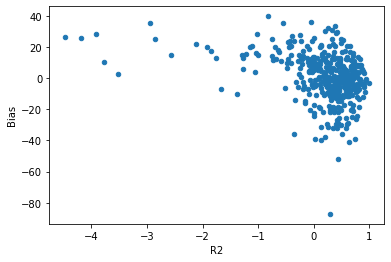

In [38]:
locations['projection'][['R2', 'Bias']].plot.scatter('R2', 'Bias')

In [39]:
locations['projection'][locations['projection'].Bias < 0].reset_index().describe()

,Latitude,Longitude,Count,RMSE,R2,Bias,Uncertainty,NumSamples
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,40.151741,-111.298507,48.830846,29.353268,0.398544,-11.550831,9.593629,48.830846
std,4.674731,8.055306,36.924805,14.269427,0.347590,11.422976,1.622669,36.924805
min,26.500000,-124.000000,10.000000,4.320200,-1.676600,-87.116000,6.490231,10.000000
25%,37.500000,-117.000000,25.000000,19.445200,0.252400,-17.213400,8.430432,25.000000
50%,40.500000,-111.500000,37.000000,26.803000,0.435400,-7.709200,9.680392,37.000000
75%,43.500000,-107.500000,60.000000,36.044800,0.632800,-3.936600,10.582354,60.000000
max,49.000000,-68.500000,203.000000,111.676000,0.990600,-0.178800,16.792282,203.000000


In [40]:
locations['projection'][locations['projection'].Bias > 0].reset_index().describe()

,Latitude,Longitude,Count,RMSE,R2,Bias,Uncertainty,NumSamples
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,38.886256,-110.414692,53.886256,23.150659,-0.005320,11.931579,9.490903,53.886256
std,4.830099,8.029400,57.595026,9.179614,0.912614,8.521982,1.651750,57.595026
min,30.000000,-124.500000,10.000000,7.166400,-4.484200,0.104200,6.495604,10.000000
25%,35.000000,-116.750000,26.000000,16.868100,-0.216100,5.009400,8.424216,26.000000
50%,39.000000,-111.000000,41.000000,21.466600,0.244200,10.422400,9.432770,41.000000
75%,42.750000,-106.000000,55.000000,27.689800,0.555500,16.767400,10.454173,55.000000
max,49.000000,-79.000000,528.000000,69.069400,0.896400,39.673800,15.683503,528.000000


array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
      dtype=object)

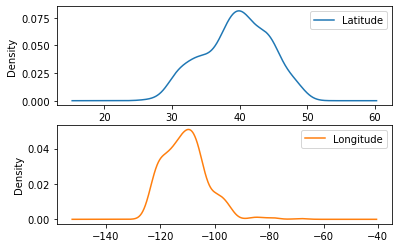

In [41]:
locations['projection'].reset_index()[['Latitude', 'Longitude']].plot.density(subplots=True, sharex=False)

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
      dtype=object)

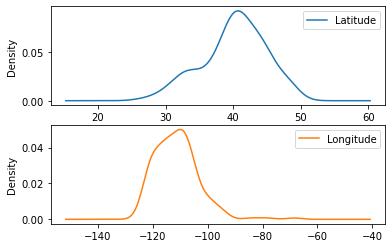

In [42]:
locations['projection'][locations['projection'].Bias < 0].reset_index()[['Latitude', 'Longitude']].plot.density(subplots=True, sharex=False)

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
      dtype=object)

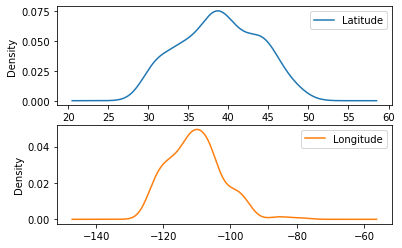

In [43]:
locations['projection'][locations['projection'].Bias > 0].reset_index()[['Latitude', 'Longitude']].plot.density(subplots=True, sharex=False)

In [44]:
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='Density'>

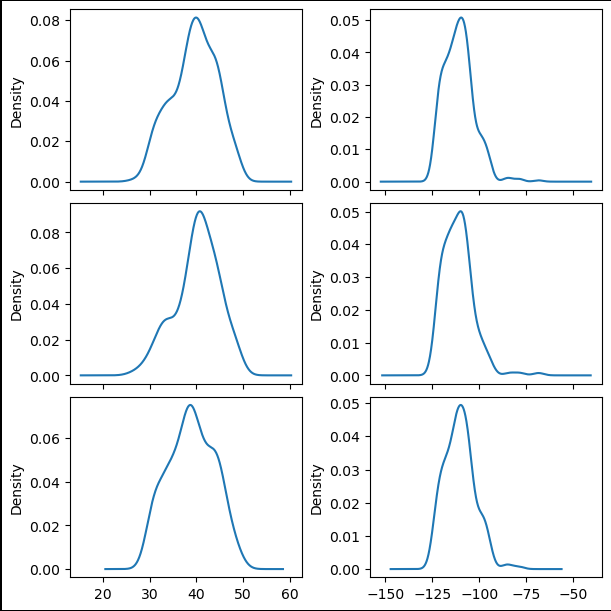

In [45]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(6, 6), sharex='col', #sharey='row', #
    constrained_layout=True, dpi=100, linewidth=2, edgecolor="black")
locations['projection'].reset_index()['Latitude'].plot.density(ax=ax1)
locations['projection'][locations['projection'].Bias < 0].reset_index()['Latitude'].plot.density(ax=ax3)
locations['projection'][locations['projection'].Bias > 0].reset_index()['Latitude'].plot.density(ax=ax5)
locations['projection'].reset_index()['Longitude'].plot.density(ax=ax2)
locations['projection'][locations['projection'].Bias < 0].reset_index()['Longitude'].plot.density(ax=ax4)
locations['projection'][locations['projection'].Bias > 0].reset_index()['Longitude'].plot.density(ax=ax6)

<AxesSubplot:ylabel='Density'>

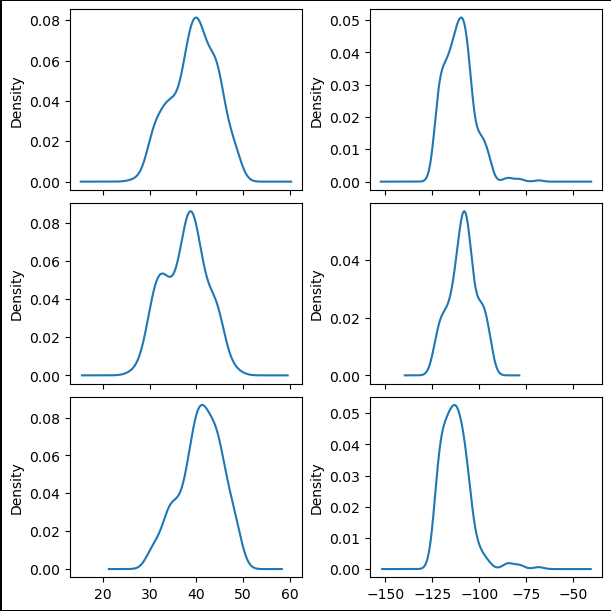

In [46]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(6, 6), sharex='col', #sharey='row', #
    constrained_layout=True, dpi=100, linewidth=2, edgecolor="black")
locations['differences'].reset_index()['Latitude'].plot.density(ax=ax1)
locations['differences'][locations['differences'].Bias < 0].reset_index()['Latitude'].plot.density(ax=ax3)
locations['differences'][locations['differences'].Bias > 0].reset_index()['Latitude'].plot.density(ax=ax5)
locations['differences'].reset_index()['Longitude'].plot.density(ax=ax2)
locations['differences'][locations['differences'].Bias < 0].reset_index()['Longitude'].plot.density(ax=ax4)
locations['differences'][locations['differences'].Bias > 0].reset_index()['Longitude'].plot.density(ax=ax6)

In [48]:
locations['projection']

Count      RMSE      R2     Bias  Uncertainty  NumSamples
Latitude Longitude                                                           
26.5     -99.0       15.0  111.6760  0.2820 -87.1160    15.051169          15
28.5     -99.5       42.0   73.7666  0.4326 -51.6842    14.107915          42
         -98.5       41.0   68.0646  0.4086 -32.2604    13.557655          41
29.5     -103.5      35.0   14.3700  0.3222  -7.7092     8.097753          35
30.0     -100.5      48.0   23.3972  0.2038  12.7828    12.453437          48
...                   ...       ...     ...      ...          ...         ...
48.5     -114.0      57.0   96.8254  0.1240 -39.5670    11.975794          57
49.0     -117.5      23.0   30.6978 -0.2384  23.6270     9.594637          23
         -117.0      27.0   21.7176  0.9194  -9.1204    11.409005          27
         -116.5      37.0   57.7266  0.5036 -36.1626     9.975861          37
         -114.0      31.0   28.0990  0.4464  -2.5854    10.630041          31

[412 rows x 6 columns]

In [55]:
predict2 = predict.merge(samples[['Latitude', 'Longitude', 'LFMC value']], left_index=True, right_index=True)
predict2['Latitude'] = np.ceil((predict2.Latitude * 2))/2
predict2['Longitude'] = np.floor((predict2.Longitude * 2))/2
predict2

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,Latitude,Longitude,LFMC value
ID,,,,,,,,,,,,,,,,,,,,,
C6_17_126,143.570,141.273,139.210,141.218,142.698,140.535,137.345,138.729,140.210,139.885,...,142.089,139.578,141.824,137.792,140.487,141.351,138.861,45.0,-108.0,138.33333
C6_17_129,148.161,144.659,142.678,147.140,146.921,144.826,142.202,144.272,143.903,144.572,...,145.940,144.510,146.322,142.027,144.974,145.097,142.879,45.0,-108.0,151.66667
C6_17_132,145.319,143.031,142.152,144.059,142.469,143.061,141.527,141.480,141.799,141.383,...,143.859,141.160,144.992,140.836,141.553,142.833,143.022,45.0,-108.0,133.33333
C6_17_135,136.646,136.064,134.176,134.506,134.890,135.519,134.799,134.113,134.839,133.085,...,136.209,132.763,137.203,133.615,133.498,136.344,135.776,45.0,-108.0,129.00000
C6_17_138,124.199,123.466,121.477,120.238,120.890,122.664,122.008,120.880,121.449,120.258,...,122.430,121.398,124.152,120.266,119.173,122.451,121.940,45.0,-108.0,113.66667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C6_930_218,127.094,129.943,128.148,123.578,125.669,127.876,129.052,124.768,127.164,130.720,...,126.387,127.763,125.722,129.599,126.453,128.967,130.006,32.0,-96.0,113.50000
C6_930_220,136.637,136.672,135.142,133.925,134.687,134.273,137.260,134.532,136.310,138.303,...,132.844,136.103,136.409,139.335,136.077,137.307,138.888,32.0,-96.0,146.00000
C6_930_221,125.044,124.910,124.338,121.390,124.047,121.351,123.976,122.630,123.776,124.854,...,122.562,122.964,125.081,125.668,122.792,124.647,124.473,32.0,-96.0,151.00000


In [58]:
samples2 = samples.copy()
samples2['Latitude'] = np.ceil((samples2.Latitude * 2))/2
samples2['Longitude'] = np.floor((samples2.Longitude * 2))/2
samples2

,Latitude,Longitude,Sampling date,Sampling year,Land Cover,LFMC value,Site,Czone1,Czone2,Czone3,Day_sin,Day_cos,Long_sin,Long_cos,Lat_norm,Elevation,Slope,Aspect_sin,Aspect_cos
ID,,,,,,,,,,,,,,,,,,,
C6_17_126,45.0,-108.0,2017-06-22,2017,"Tree cover, needleleaved, evergreen, closed to...",138.33333,C6_17,D,Df,Dfc,-0.17977,0.98371,-0.95366,-0.30088,0.74786,0.43411,0.06524,0.61539,0.78822
C6_17_129,45.0,-108.0,2017-07-05,2017,"Tree cover, needleleaved, evergreen, closed to...",151.66667,C6_17,D,Df,Dfc,0.04302,0.99907,-0.95366,-0.30088,0.74786,0.43411,0.06524,0.61539,0.78822
C6_17_132,45.0,-108.0,2017-07-20,2017,"Tree cover, needleleaved, evergreen, closed to...",133.33333,C6_17,D,Df,Dfc,0.29671,0.95497,-0.95366,-0.30088,0.74786,0.43411,0.06524,0.61539,0.78822
C6_17_135,45.0,-108.0,2017-08-03,2017,"Tree cover, needleleaved, evergreen, closed to...",129.00000,C6_17,D,Df,Dfc,0.51606,0.85655,-0.95366,-0.30088,0.74786,0.43411,0.06524,0.61539,0.78822
C6_17_138,45.0,-108.0,2017-08-17,2017,"Tree cover, needleleaved, evergreen, closed to...",113.66667,C6_17,D,Df,Dfc,0.70558,0.70863,-0.95366,-0.30088,0.74786,0.43411,0.06524,0.61539,0.78822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C6_930_218,32.0,-96.0,2014-10-01,2014,Mosaic herbaceous cover (>50%) / tree and shru...,113.50000,C6_930,C,Cf,Cfa,0.99992,0.01291,-0.99512,-0.09868,0.67652,0.02486,0.06335,-0.06403,0.99795
C6_930_220,32.0,-96.0,2014-11-01,2014,Mosaic herbaceous cover (>50%) / tree and shru...,146.00000,C6_930,C,Cf,Cfa,0.86746,-0.49751,-0.99512,-0.09868,0.67652,0.02486,0.06335,-0.06403,0.99795
C6_930_221,32.0,-96.0,2014-12-01,2014,Mosaic herbaceous cover (>50%) / tree and shru...,151.00000,C6_930,C,Cf,Cfa,0.50867,-0.86096,-0.99512,-0.09868,0.67652,0.02486,0.06335,-0.06403,0.99795


<AxesSubplot:ylabel='Density'>

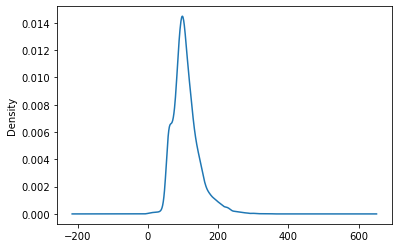

In [59]:
samples2['LFMC value'].plot.density()

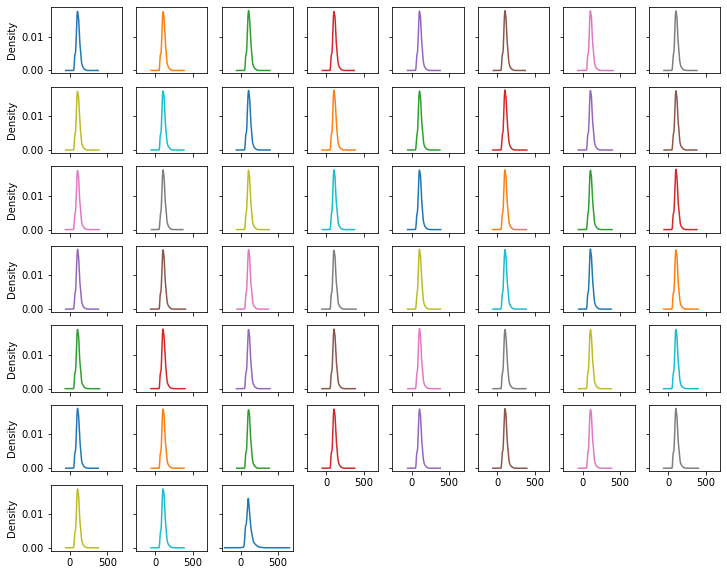

In [70]:
_ = predict2.drop(columns=['Latitude', 'Longitude']).plot.density(subplots=True, layout=(7,8), figsize=(12, 10), sharex=True, sharey=True, legend=False)

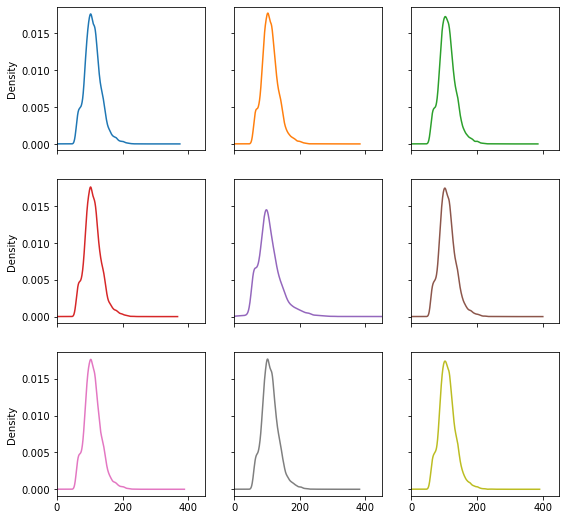

In [80]:
_ = predict2[['5', '23', '46', '17', 'LFMC value', '39', '2', '28', '34']].plot.density(subplots=True, layout=(3, 3), figsize=(9, 9),
                                                                                        sharex=True, sharey=True, legend=False, xlim=(0,450))

In [73]:
predict.kurtosis().mean()

1.2693692949398612

In [76]:
samples['LFMC value'].kurtosis()

3.2277075585237056

In [93]:
g2 = (((samples['LFMC value'] - samples['LFMC value'].mean())/samples['LFMC value'].std(ddof=0)) ** 4).mean() - 3
n = len(samples['LFMC value'])
G2 = (n-1) / ((n-2)*(n-3)) * ((n+1) * g2 + 6)
G2

3.2277075585237043

In [90]:
len(samples['LFMC value'])

21520

In [88]:
predict_now = pd.read_csv(os.path.join(MODEL_DIR, tests[0]['dir'], ifile_name), index_col=0)
predict_now.kurtosis().mean()

1.1621758641790318

(0.0, 1.0)

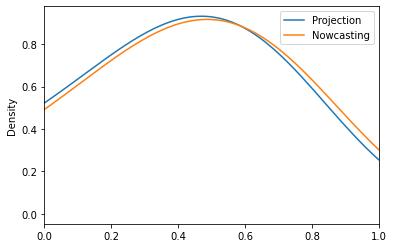

In [24]:
ax = pd.concat([locations['projection']['R2'], locations['nowcasting']['R2']], axis=1, keys=['Projection', 'Nowcasting']).plot.density()
ax.set_xlim([0, 1])

(0.0, 100.0)

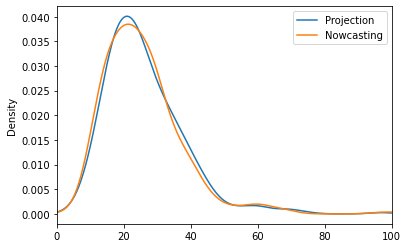

In [28]:
ax = pd.concat([locations['projection']['RMSE'], locations['nowcasting']['RMSE']], axis=1, keys=['Projection', 'Nowcasting']).plot.density()
ax.set_xlim([0, 100])

(-50.0, 50.0)

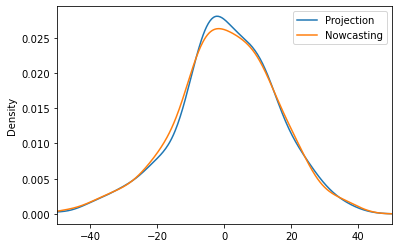

In [29]:
ax = pd.concat([locations['projection']['Bias'], locations['nowcasting']['Bias']], axis=1, keys=['Projection', 'Nowcasting']).plot.density()
ax.set_xlim([-50, 50])

In [22]:
pd.concat([locations['projection']['R2'], locations['nowcasting']['R2'], locations['differences']['R2']],
          axis=1,
          keys=['Projection', 'Nowcasting', 'Differences']
         ).quantile([0, .10, .20, .30, .40, .50, .60, .70, .80, .90, 1])

,Projection,Nowcasting,Differences
0.0,-4.48420,-4.93140,-0.85360
0.1,-0.42366,-0.43304,-0.17950
0.2,-0.05012,-0.01348,-0.10800
0.3,0.12878,0.14794,-0.06862
0.4,0.26952,0.29136,-0.04452
0.5,0.36360,0.39010,-0.02780
0.6,0.45136,0.48764,-0.00976
0.7,0.56516,0.57056,0.01652
0.8,0.64400,0.66516,0.06504
0.9,0.74964,0.79674,0.16526


In [56]:
pd.concat([locations['projection']['R2'], locations['nowcasting']['R2'], locations['differences']['R2']],
          axis=1,
          keys=['Projection', 'Nowcasting', 'Differences']
         ).quantile([0, .25, .50, .75, 1])

,Projection,Nowcasting,Differences
0.00,-4.48420,-4.93140,-0.85360
0.25,0.03150,0.07065,-0.08720
0.50,0.36360,0.39010,-0.02780
0.75,0.59385,0.62245,0.02965
1.00,0.99060,0.99000,0.81740


<AxesSubplot:xlabel='R2', ylabel='Count'>

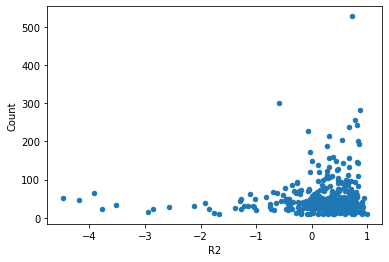

In [31]:
locations['projection'].plot.scatter('R2', 'Count')

<AxesSubplot:xlabel='R2', ylabel='Count'>

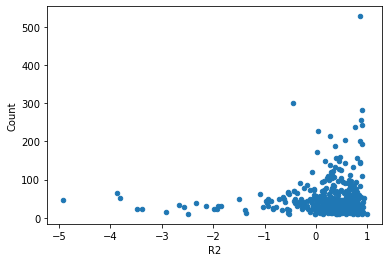

In [32]:
locations['nowcasting'].plot.scatter('R2', 'Count')

In [33]:
locations['projection'][locations['projection'].Count >= 300]

,,Count,RMSE,R2,Bias,Uncertainty,NumSamples
Latitude,Longitude,,,,,,
30.5,-98.0,300.0,21.9298,-0.5938,10.8598,10.762477,300
34.5,-119.0,528.0,21.6354,0.7156,11.2440,9.773398,528


In [34]:
locations['projection'][locations['projection'].R2 < 0].describe()

,Count,RMSE,R2,Bias,Uncertainty,NumSamples
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,46.127660,25.993579,-0.740953,10.691419,9.273600,46.127660
std,41.185193,9.015516,0.998437,13.643050,1.649829,41.185193
min,10.000000,12.748600,-4.484200,-35.712600,6.659774,10.000000
25%,24.250000,20.849900,-0.952900,3.713750,8.362752,24.250000
50%,37.000000,24.595300,-0.360400,12.592000,9.038063,37.000000
75%,51.250000,30.250100,-0.117300,20.156400,10.112445,51.250000
max,300.000000,69.069400,-0.002600,39.673800,15.325358,300.000000


In [36]:
locations['projection'][locations['projection'].R2 > 0].describe()

,Count,RMSE,R2,Bias,Uncertainty,NumSamples
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,52.984277,26.230816,0.467404,-2.544488,9.620068,52.984277
std,50.573023,13.149980,0.232996,14.655905,1.626657,50.573023
min,10.000000,4.320200,0.005400,-87.116000,6.490231,10.000000
25%,26.000000,17.444050,0.286600,-9.068950,8.450785,26.000000
50%,40.000000,23.638700,0.466400,-1.777000,9.685903,40.000000
75%,59.500000,32.697700,0.653700,6.795150,10.630036,59.500000
max,528.000000,111.676000,0.990600,33.708200,16.792282,528.000000


In [43]:
locations.keys()

dict_keys(['nowcasting', 'projection', 'differences', 'LFMC_stats'])

In [48]:
samples_temp = samples[['Longitude', 'Latitude', 'LFMC value']].copy()
samples_temp['Latitude'] = np.ceil((samples_temp.Latitude * 2))/2
samples_temp['Longitude'] = np.floor((samples_temp.Longitude * 2))/2
locations['LFMC_stats'] = samples_temp.groupby(['Longitude', 'Latitude']).describe().droplevel(0, axis=1)

In [51]:
locations['projection'][locations['projection'].R2 < 0].merge(locations['LFMC_stats']['std'], left_index=True, right_index=True).describe()

,Count,RMSE,R2,Bias,Uncertainty,NumSamples,std
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,46.127660,25.993579,-0.740953,10.691419,9.273600,46.127660,18.901910
std,41.185193,9.015516,0.998437,13.643050,1.649829,41.185193,8.251761
min,10.000000,12.748600,-4.484200,-35.712600,6.659774,10.000000,7.037130
25%,24.250000,20.849900,-0.952900,3.713750,8.362752,24.250000,13.834518
50%,37.000000,24.595300,-0.360400,12.592000,9.038063,37.000000,17.283578
75%,51.250000,30.250100,-0.117300,20.156400,10.112445,51.250000,22.877415
max,300.000000,69.069400,-0.002600,39.673800,15.325358,300.000000,68.566713


In [54]:
locations['LFMC_stats']['std'].describe()

count    469.000000
mean      26.368117
std       14.976609
min        1.178514
25%       15.174537
50%       22.569585
75%       35.623229
max       76.390978
Name: std, dtype: float64

In [55]:
locations['LFMC_stats'][locations['LFMC_stats']['count'] == 300]

,,count,mean,std,min,25%,50%,75%,max
Longitude,Latitude,,,,,,,,
-98.0,30.5,300.0,107.758333,17.387212,61.0,97.0,104.0,116.125,173.0
